<a href="https://colab.research.google.com/github/sethharris17/DA-6813-901-Data-Analytics-Applications/blob/main/Seth_Harris_IS6733Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Neural Network to Predict Quality of Wine
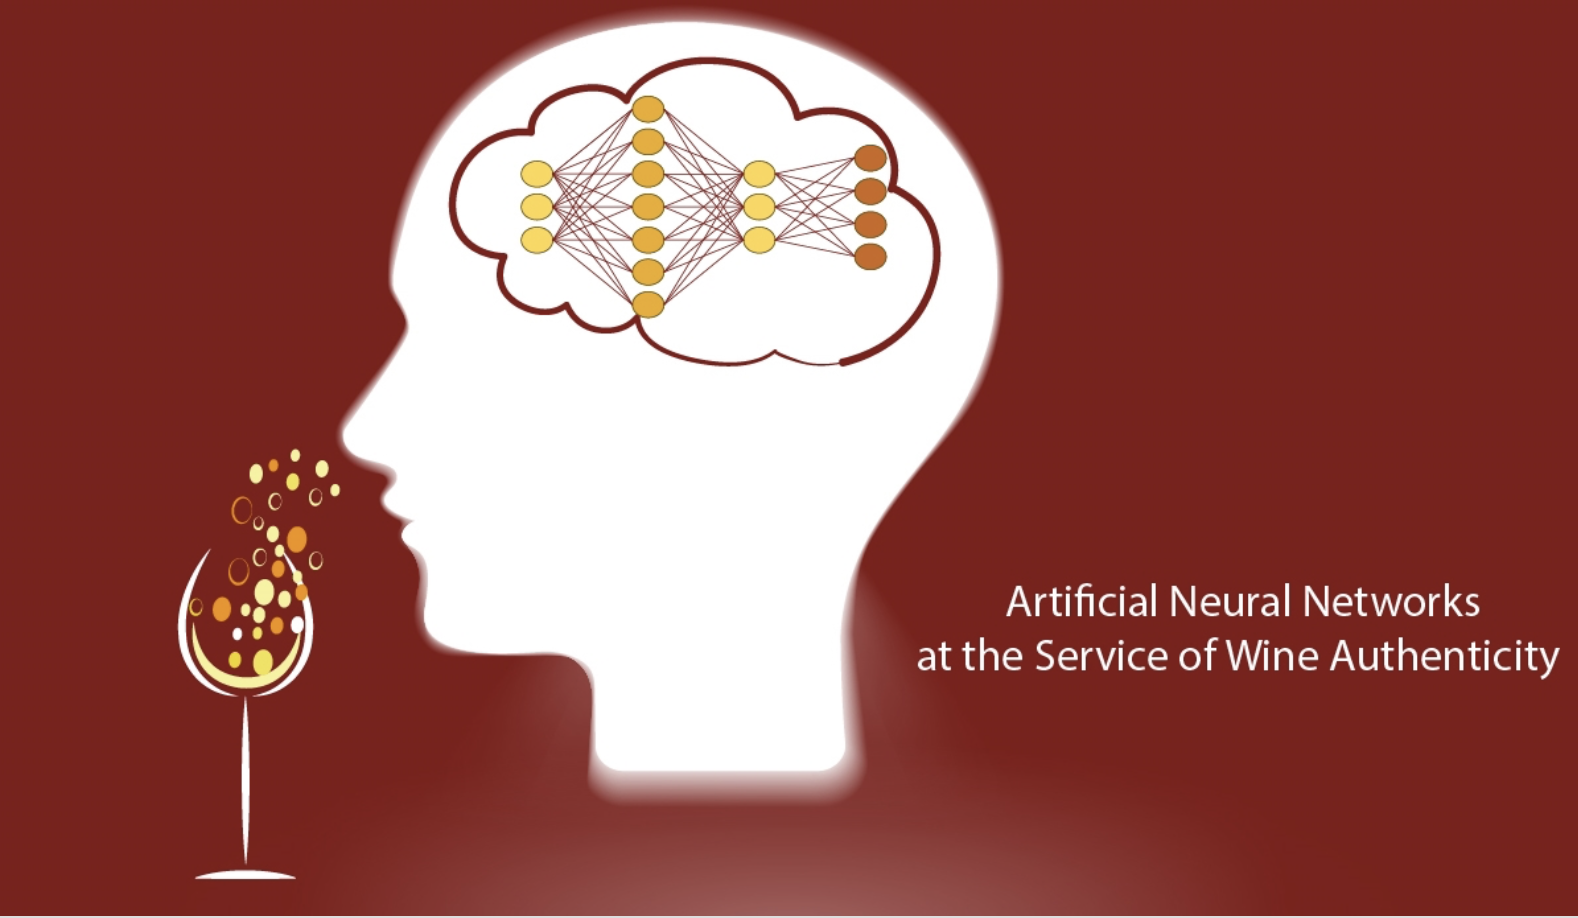
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


## Imports

In [128]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [129]:
data_df = pd.read_csv('/content/drive/My Drive/winequality-red.csv')


In [130]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [131]:
# how many features?
len(data_df.columns) - 1

11

In [132]:
# list the label names
print(data_df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [133]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [134]:
# convert these quaity measures to labels (0 to 5)
def get_label(quality):
    if quality == 3:
        return 0
    elif quality == 4:
        return 1
    elif quality == 5:
        return 2
    elif quality == 6:
        return 3
    elif quality == 7:
        return 4
    else:
        return 5

labels = data_df['quality'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [135]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   
1      -0.298454          1.966827    -1.391037        0.043403   0.223805   
2      -0.298454          1.296660    -1.185699       -0.169374   0.096323   
3       1.654339         -1.384011     1.483689       -0.453077  -0.264878   
4      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466047             -0.379014  0.558100  1.288240  -0.579025   
1             0.872365              0.624168  0.028252 -0.719708   0.128910   
2            -0.083643              0.228975  0.134222 -0.331073  -0.048074   
3             0.107558              0.411372  0.664069 -0.978798  -0.461036   
4            -0.466047             -0.379014  0.558100  1.288240  -0.579025   

    alcohol   quality  label  
0 -0.959946 -0.787576      2  
1 -0.584594 -0.787576      2  
2 -0.584594 -0.787576      2  
3 -0.584594  0.450707      3  
4 -0.959946 -0.787576      2

In [136]:
# sumamry statistics of the data
data_df.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.599000e+03      1.599000e+03  1.599000e+03    1.599000e+03   
mean    3.554936e-16      1.688594e-16 -1.066481e-16   -1.110917e-16   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.136377e+00     -2.277567e+00 -1.391037e+00   -1.162333e+00   
25%    -7.004996e-01     -7.696903e-01 -9.290275e-01   -4.530767e-01   
50%    -2.410190e-01     -4.367545e-02 -5.634264e-02   -2.402999e-01   
75%     5.056370e-01      6.264921e-01  7.650078e-01    4.340257e-02   
max     4.353787e+00      5.876138e+00  3.742403e+00    9.192806e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.599000e+03         1.599000e+03          1.599000e+03  1.599000e+03   
mean   2.132961e-16        -6.221137e-17          2.666202e-17 -3.469617e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.603443e+00        -1.422055e+00         -1.230199e+00 -3.537625e+00   
25%   -3.711129e-01        -8.484502e-01         -7.438076e-01 -6.075656e-01   
50%   -1.798892e-01        -1.792441e-01         -2.574163e-01  1.759533e-03   
75%    5.382858e-02         4.899619e-01          4.721707e-01  5.766445e-01   
max    1.112355e+01         5.365606e+00          7.372847e+00  3.678904e+00   

                 pH     sulphates       alcohol       quality        label  
count  1.599000e+03  1.599000e+03  1.599000e+03  1.599000e+03  1599.000000  
mean   2.861723e-15  6.665504e-16  7.109871e-17  6.221137e-17     2.636023  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00     0.807569  
min   -3.699244e+00 -1.935902e+00 -1.898325e+00 -3.264143e+00     0.000000  
25%   -6.549356e-01 -6.380200e-01 -8.661079e-01 -7.875763e-01     2.000000  
50%   -7.210449e-03 -2.250577e-01 -2.092427e-01  4.507074e-01     3.000000  
75%    5.757422e-01  4.238832e-01  6.352984e-01  4.507074e-01     3.000000  
max    4.526866e+00  7.916200e+00  4.201138e+00  2.927275e+00     5.000000

## Load this dataset for training a neural network

In [137]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['fixed acidity'], i['volatile acidity'], i['citric acid'], i['residual sugar'], i['chlorides'], i['free sulfur dioxide'], i['total sulfur dioxide'], i['density'], i['pH'], i['sulphates'], i['alcohol']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [138]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(2), 'features': tensor([-0.5282,  0.9616, -1.3910, -0.4531, -0.2436, -0.4660, -0.3790,  0.5581,
         1.2882, -0.5790, -0.9599])}


## Neural Network

In [139]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [140]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

winemodel = WineModel().to(device)

## Training

In [141]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr = 1e-3)

In [142]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [143]:
# Let's train our model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


| Epoch: 01 | Train Loss: 1.521 | Train Acc: 56.09% | Val. Loss: 1.456 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.460 | Train Acc: 58.67% | Val. Loss: 1.449 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.450 | Train Acc: 59.22% | Val. Loss: 1.444 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.443 | Train Acc: 60.16% | Val. Loss: 1.438 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.439 | Train Acc: 60.78% | Val. Loss: 1.433 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.434 | Train Acc: 61.25% | Val. Loss: 1.428 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.430 | Train Acc: 62.34% | Val. Loss: 1.429 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.428 | Train Acc: 61.80% | Val. Loss: 1.424 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.425 | Train Acc: 62.03% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.421 | Train Acc: 62.97% | Val. Loss: 1.417 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.422 | Train Acc: 62.50% | Val. Loss: 1.413 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.418 | Train Acc: 63.05% | Val. Loss: 1.415 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.414 | Train Acc: 63.20% | Val. Loss: 1.411 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.413 | Train Acc: 63.12% | Val. Loss: 1.411 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.412 | Train Acc: 63.44% | Val. Loss: 1.409 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.412 | Train Acc: 63.52% | Val. Loss: 1.415 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.410 | Train Acc: 63.83% | Val. Loss: 1.412 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.410 | Train Acc: 63.83% | Val. Loss: 1.417 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.406 | Train Acc: 64.45% | Val. Loss: 1.414 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.407 | Train Acc: 63.52% | Val. Loss: 1.409 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.404 | Train Acc: 64.69% | Val. Loss: 1.407 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.403 | Train Acc: 64.69% | Val. Loss: 1.407 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.404 | Train Acc: 64.77% | Val. Loss: 1.412 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.401 | Train Acc: 64.77% | Val. Loss: 1.399 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.402 | Train Acc: 64.92% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.399 | Train Acc: 65.16% | Val. Loss: 1.407 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.398 | Train Acc: 65.47% | Val. Loss: 1.408 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.398 | Train Acc: 65.31% | Val. Loss: 1.406 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.397 | Train Acc: 65.55% | Val. Loss: 1.401 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.396 | Train Acc: 65.39% | Val. Loss: 1.404 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.394 | Train Acc: 65.55% | Val. Loss: 1.408 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.394 | Train Acc: 66.09% | Val. Loss: 1.402 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.395 | Train Acc: 65.16% | Val. Loss: 1.400 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.393 | Train Acc: 65.62% | Val. Loss: 1.404 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.393 | Train Acc: 65.31% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.394 | Train Acc: 65.47% | Val. Loss: 1.397 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.393 | Train Acc: 65.62% | Val. Loss: 1.395 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.392 | Train Acc: 65.55% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.390 | Train Acc: 65.70% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.391 | Train Acc: 65.78% | Val. Loss: 1.412 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.391 | Train Acc: 65.55% | Val. Loss: 1.401 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.390 | Train Acc: 65.86% | Val. Loss: 1.397 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.388 | Train Acc: 66.17% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.389 | Train Acc: 66.02% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.388 | Train Acc: 66.09% | Val. Loss: 1.405 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.388 | Train Acc: 66.17% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.387 | Train Acc: 66.25% | Val. Loss: 1.411 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.390 | Train Acc: 65.86% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.387 | Train Acc: 65.94% | Val. Loss: 1.404 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.387 | Train Acc: 66.09% | Val. Loss: 1.400 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.386 | Train Acc: 66.64% | Val. Loss: 1.399 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.384 | Train Acc: 66.48% | Val. Loss: 1.403 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.386 | Train Acc: 66.17% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.386 | Train Acc: 66.09% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.385 | Train Acc: 66.25% | Val. Loss: 1.406 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.383 | Train Acc: 66.64% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.382 | Train Acc: 66.64% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.383 | Train Acc: 66.88% | Val. Loss: 1.398 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.383 | Train Acc: 66.88% | Val. Loss: 1.386 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.381 | Train Acc: 66.88% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.384 | Train Acc: 66.48% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.382 | Train Acc: 66.56% | Val. Loss: 1.402 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.382 | Train Acc: 66.64% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.382 | Train Acc: 66.56% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.380 | Train Acc: 66.95% | Val. Loss: 1.397 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.380 | Train Acc: 66.80% | Val. Loss: 1.397 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.381 | Train Acc: 66.64% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.380 | Train Acc: 66.80% | Val. Loss: 1.401 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.381 | Train Acc: 66.95% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.379 | Train Acc: 66.95% | Val. Loss: 1.387 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.379 | Train Acc: 67.03% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.377 | Train Acc: 67.03% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.379 | Train Acc: 66.72% | Val. Loss: 1.391 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.377 | Train Acc: 67.03% | Val. Loss: 1.395 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.375 | Train Acc: 67.27% | Val. Loss: 1.413 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.378 | Train Acc: 67.27% | Val. Loss: 1.393 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.374 | Train Acc: 67.50% | Val. Loss: 1.390 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.373 | Train Acc: 67.34% | Val. Loss: 1.388 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.374 | Train Acc: 67.73% | Val. Loss: 1.405 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.374 | Train Acc: 67.42% | Val. Loss: 1.389 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.373 | Train Acc: 67.34% | Val. Loss: 1.386 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.371 | Train Acc: 68.05% | Val. Loss: 1.391 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.369 | Train Acc: 68.12% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.369 | Train Acc: 67.89% | Val. Loss: 1.386 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.369 | Train Acc: 68.20% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.373 | Train Acc: 67.42% | Val. Loss: 1.384 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.370 | Train Acc: 67.73% | Val. Loss: 1.391 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.369 | Train Acc: 68.05% | Val. Loss: 1.393 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.368 | Train Acc: 67.97% | Val. Loss: 1.378 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.366 | Train Acc: 68.28% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.366 | Train Acc: 67.97% | Val. Loss: 1.402 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.364 | Train Acc: 68.36% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.354 | Train Acc: 69.38% | Val. Loss: 1.378 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.348 | Train Acc: 70.16% | Val. Loss: 1.380 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.344 | Train Acc: 70.31% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.347 | Train Acc: 70.47% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.342 | Train Acc: 70.70% | Val. Loss: 1.387 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.343 | Train Acc: 70.86% | Val. Loss: 1.395 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.337 | Train Acc: 71.72% | Val. Loss: 1.388 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.335 | Train Acc: 71.56% | Val. Loss: 1.375 | Val. Acc: 67.50% |


# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)

In [149]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature set and y is the target
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# This results in 60% training, 20% validation, and 20% test

In [150]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_with_metrics(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predicted class (the index of the max logit value)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

In [152]:
class WineModel(nn.Module):
    def __init__(self):
        super(WineModel, self).__init__()
        self.fc1 = nn.Linear(4, 128)  # Adjusted input size to match the number of features (4)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)   # Adjust the output to match the number of classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [153]:
print(X_train.shape)  # Should output something like (n_samples, 4)


(90, 4)


In [144]:
# Assuming we have an evaluate function like this for the validation
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Final Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}% |')

| Final Test Loss: 1.429 | Test Accuracy: 60.42% |


## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

In [ ]:
# Increasing the number of epochs (from current 100 to 200)
num_epochs = 200

# Increasing the learning rate with adjustment
optimizer = AdamW(winemodel.parameters(), lr = 2e-3)

# Training the model with increased epochs
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*200:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*200:.2f}% |')

# Evaluating the model on the test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Final Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*200:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


| Epoch: 01 | Train Loss: 1.304 | Train Acc: 151.09% | Val. Loss: 1.379 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.306 | Train Acc: 149.38% | Val. Loss: 1.391 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.302 | Train Acc: 150.31% | Val. Loss: 1.377 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.307 | Train Acc: 149.53% | Val. Loss: 1.390 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.299 | Train Acc: 150.94% | Val. Loss: 1.388 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.302 | Train Acc: 150.16% | Val. Loss: 1.392 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.298 | Train Acc: 151.41% | Val. Loss: 1.386 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.296 | Train Acc: 151.56% | Val. Loss: 1.387 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.302 | Train Acc: 150.00% | Val. Loss: 1.396 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.302 | Train Acc: 150.00% | Val. Loss: 1.393 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.297 | Train Acc: 151.56% | Val. Loss: 1.394 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.296 | Train Acc: 151.56% | Val. Loss: 1.395 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.301 | Train Acc: 150.62% | Val. Loss: 1.399 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.300 | Train Acc: 150.78% | Val. Loss: 1.397 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.302 | Train Acc: 150.00% | Val. Loss: 1.394 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.294 | Train Acc: 152.34% | Val. Loss: 1.385 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.300 | Train Acc: 150.62% | Val. Loss: 1.383 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.296 | Train Acc: 151.56% | Val. Loss: 1.386 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.295 | Train Acc: 151.72% | Val. Loss: 1.386 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.295 | Train Acc: 151.09% | Val. Loss: 1.385 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.294 | Train Acc: 152.03% | Val. Loss: 1.388 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.295 | Train Acc: 152.34% | Val. Loss: 1.398 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.295 | Train Acc: 151.41% | Val. Loss: 1.381 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.296 | Train Acc: 151.56% | Val. Loss: 1.391 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.294 | Train Acc: 152.03% | Val. Loss: 1.387 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.294 | Train Acc: 151.72% | Val. Loss: 1.384 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.290 | Train Acc: 152.81% | Val. Loss: 1.380 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.293 | Train Acc: 151.72% | Val. Loss: 1.388 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.291 | Train Acc: 152.50% | Val. Loss: 1.369 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.299 | Train Acc: 150.94% | Val. Loss: 1.380 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.293 | Train Acc: 152.34% | Val. Loss: 1.380 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.289 | Train Acc: 152.34% | Val. Loss: 1.383 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.287 | Train Acc: 153.59% | Val. Loss: 1.380 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.290 | Train Acc: 151.88% | Val. Loss: 1.385 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.290 | Train Acc: 152.97% | Val. Loss: 1.387 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.289 | Train Acc: 152.03% | Val. Loss: 1.375 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.284 | Train Acc: 153.91% | Val. Loss: 1.385 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.295 | Train Acc: 152.19% | Val. Loss: 1.381 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.286 | Train Acc: 153.44% | Val. Loss: 1.379 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.287 | Train Acc: 152.34% | Val. Loss: 1.371 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.284 | Train Acc: 154.38% | Val. Loss: 1.372 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.281 | Train Acc: 154.22% | Val. Loss: 1.382 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.281 | Train Acc: 154.38% | Val. Loss: 1.376 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.286 | Train Acc: 152.81% | Val. Loss: 1.389 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.285 | Train Acc: 153.75% | Val. Loss: 1.377 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.285 | Train Acc: 153.12% | Val. Loss: 1.365 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.283 | Train Acc: 154.06% | Val. Loss: 1.367 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.278 | Train Acc: 155.00% | Val. Loss: 1.385 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.282 | Train Acc: 154.22% | Val. Loss: 1.369 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.284 | Train Acc: 152.97% | Val. Loss: 1.386 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.283 | Train Acc: 152.97% | Val. Loss: 1.374 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.292 | Train Acc: 151.88% | Val. Loss: 1.378 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.279 | Train Acc: 155.00% | Val. Loss: 1.387 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.286 | Train Acc: 153.28% | Val. Loss: 1.369 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.285 | Train Acc: 152.97% | Val. Loss: 1.368 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.284 | Train Acc: 153.44% | Val. Loss: 1.361 | Val. Acc: 140.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.278 | Train Acc: 155.16% | Val. Loss: 1.370 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.279 | Train Acc: 155.00% | Val. Loss: 1.367 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.275 | Train Acc: 155.00% | Val. Loss: 1.377 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.276 | Train Acc: 154.69% | Val. Loss: 1.372 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.278 | Train Acc: 154.69% | Val. Loss: 1.369 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.283 | Train Acc: 153.75% | Val. Loss: 1.369 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.273 | Train Acc: 155.78% | Val. Loss: 1.361 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.275 | Train Acc: 155.31% | Val. Loss: 1.353 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.278 | Train Acc: 154.84% | Val. Loss: 1.368 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.281 | Train Acc: 154.06% | Val. Loss: 1.379 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.277 | Train Acc: 155.16% | Val. Loss: 1.374 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.277 | Train Acc: 154.84% | Val. Loss: 1.364 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.282 | Train Acc: 153.44% | Val. Loss: 1.386 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.283 | Train Acc: 153.91% | Val. Loss: 1.362 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.278 | Train Acc: 154.22% | Val. Loss: 1.388 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.273 | Train Acc: 156.09% | Val. Loss: 1.362 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.274 | Train Acc: 156.09% | Val. Loss: 1.390 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.282 | Train Acc: 153.75% | Val. Loss: 1.372 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.283 | Train Acc: 154.06% | Val. Loss: 1.381 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.276 | Train Acc: 155.31% | Val. Loss: 1.373 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.274 | Train Acc: 155.78% | Val. Loss: 1.371 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.274 | Train Acc: 155.78% | Val. Loss: 1.361 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.278 | Train Acc: 154.84% | Val. Loss: 1.381 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.275 | Train Acc: 155.47% | Val. Loss: 1.365 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.276 | Train Acc: 154.84% | Val. Loss: 1.378 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.281 | Train Acc: 153.91% | Val. Loss: 1.370 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.271 | Train Acc: 155.78% | Val. Loss: 1.362 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.275 | Train Acc: 155.16% | Val. Loss: 1.373 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.273 | Train Acc: 155.78% | Val. Loss: 1.359 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.271 | Train Acc: 155.78% | Val. Loss: 1.374 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.272 | Train Acc: 155.94% | Val. Loss: 1.370 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.272 | Train Acc: 155.78% | Val. Loss: 1.373 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.274 | Train Acc: 155.62% | Val. Loss: 1.367 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.270 | Train Acc: 155.78% | Val. Loss: 1.368 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.271 | Train Acc: 156.41% | Val. Loss: 1.373 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.275 | Train Acc: 155.00% | Val. Loss: 1.370 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.275 | Train Acc: 155.62% | Val. Loss: 1.364 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.270 | Train Acc: 156.25% | Val. Loss: 1.379 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.276 | Train Acc: 154.69% | Val. Loss: 1.364 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.280 | Train Acc: 153.12% | Val. Loss: 1.366 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.275 | Train Acc: 155.00% | Val. Loss: 1.368 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.271 | Train Acc: 156.09% | Val. Loss: 1.367 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.269 | Train Acc: 156.56% | Val. Loss: 1.364 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.266 | Train Acc: 157.03% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 1.281 | Train Acc: 153.59% | Val. Loss: 1.370 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 1.277 | Train Acc: 154.84% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 1.271 | Train Acc: 156.25% | Val. Loss: 1.373 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 1.273 | Train Acc: 155.78% | Val. Loss: 1.363 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 1.271 | Train Acc: 156.25% | Val. Loss: 1.367 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 1.269 | Train Acc: 156.56% | Val. Loss: 1.359 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 1.270 | Train Acc: 155.78% | Val. Loss: 1.375 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 1.266 | Train Acc: 157.03% | Val. Loss: 1.358 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 1.265 | Train Acc: 157.50% | Val. Loss: 1.369 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 1.267 | Train Acc: 156.56% | Val. Loss: 1.373 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 1.268 | Train Acc: 156.25% | Val. Loss: 1.358 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 1.265 | Train Acc: 157.03% | Val. Loss: 1.366 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 1.267 | Train Acc: 157.19% | Val. Loss: 1.375 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 1.281 | Train Acc: 153.75% | Val. Loss: 1.393 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 1.279 | Train Acc: 154.84% | Val. Loss: 1.370 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 1.276 | Train Acc: 155.16% | Val. Loss: 1.375 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 1.268 | Train Acc: 156.25% | Val. Loss: 1.359 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 1.268 | Train Acc: 156.56% | Val. Loss: 1.369 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 1.273 | Train Acc: 155.78% | Val. Loss: 1.371 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 1.270 | Train Acc: 156.09% | Val. Loss: 1.356 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 1.271 | Train Acc: 155.47% | Val. Loss: 1.378 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 1.270 | Train Acc: 155.94% | Val. Loss: 1.360 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 1.265 | Train Acc: 157.50% | Val. Loss: 1.375 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 1.274 | Train Acc: 155.47% | Val. Loss: 1.372 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 1.268 | Train Acc: 156.88% | Val. Loss: 1.366 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 1.273 | Train Acc: 155.47% | Val. Loss: 1.359 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 1.268 | Train Acc: 156.25% | Val. Loss: 1.370 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 1.267 | Train Acc: 156.41% | Val. Loss: 1.367 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 1.272 | Train Acc: 155.47% | Val. Loss: 1.359 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 1.265 | Train Acc: 157.34% | Val. Loss: 1.363 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 1.267 | Train Acc: 156.56% | Val. Loss: 1.364 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 1.265 | Train Acc: 157.19% | Val. Loss: 1.361 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 1.268 | Train Acc: 156.09% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 1.272 | Train Acc: 156.09% | Val. Loss: 1.376 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 1.268 | Train Acc: 156.88% | Val. Loss: 1.385 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 1.260 | Train Acc: 157.81% | Val. Loss: 1.362 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 1.262 | Train Acc: 157.97% | Val. Loss: 1.378 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 1.271 | Train Acc: 156.09% | Val. Loss: 1.359 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 1.271 | Train Acc: 156.09% | Val. Loss: 1.372 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 1.264 | Train Acc: 157.50% | Val. Loss: 1.362 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 1.268 | Train Acc: 156.41% | Val. Loss: 1.362 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 1.271 | Train Acc: 155.78% | Val. Loss: 1.381 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 1.274 | Train Acc: 155.62% | Val. Loss: 1.374 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 1.265 | Train Acc: 157.19% | Val. Loss: 1.356 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 1.265 | Train Acc: 157.34% | Val. Loss: 1.376 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 1.265 | Train Acc: 157.19% | Val. Loss: 1.362 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 1.266 | Train Acc: 157.19% | Val. Loss: 1.364 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 1.270 | Train Acc: 155.94% | Val. Loss: 1.375 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 1.263 | Train Acc: 157.50% | Val. Loss: 1.369 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 1.268 | Train Acc: 156.09% | Val. Loss: 1.386 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 151 | Train Loss: 1.273 | Train Acc: 155.47% | Val. Loss: 1.372 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 152 | Train Loss: 1.266 | Train Acc: 157.03% | Val. Loss: 1.367 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 153 | Train Loss: 1.265 | Train Acc: 157.03% | Val. Loss: 1.366 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 154 | Train Loss: 1.266 | Train Acc: 157.19% | Val. Loss: 1.374 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 155 | Train Loss: 1.267 | Train Acc: 156.41% | Val. Loss: 1.372 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 156 | Train Loss: 1.262 | Train Acc: 157.66% | Val. Loss: 1.364 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 157 | Train Loss: 1.261 | Train Acc: 157.97% | Val. Loss: 1.377 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 158 | Train Loss: 1.267 | Train Acc: 156.88% | Val. Loss: 1.373 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 159 | Train Loss: 1.279 | Train Acc: 154.69% | Val. Loss: 1.389 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 160 | Train Loss: 1.273 | Train Acc: 155.62% | Val. Loss: 1.374 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 161 | Train Loss: 1.263 | Train Acc: 157.03% | Val. Loss: 1.371 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 162 | Train Loss: 1.266 | Train Acc: 156.88% | Val. Loss: 1.360 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 163 | Train Loss: 1.258 | Train Acc: 158.12% | Val. Loss: 1.356 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 164 | Train Loss: 1.263 | Train Acc: 157.34% | Val. Loss: 1.374 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 165 | Train Loss: 1.267 | Train Acc: 156.88% | Val. Loss: 1.355 | Val. Acc: 140.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 166 | Train Loss: 1.259 | Train Acc: 158.28% | Val. Loss: 1.363 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 167 | Train Loss: 1.260 | Train Acc: 157.97% | Val. Loss: 1.364 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 168 | Train Loss: 1.259 | Train Acc: 158.12% | Val. Loss: 1.376 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 169 | Train Loss: 1.265 | Train Acc: 157.03% | Val. Loss: 1.360 | Val. Acc: 137.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 170 | Train Loss: 1.266 | Train Acc: 156.88% | Val. Loss: 1.372 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 171 | Train Loss: 1.267 | Train Acc: 156.88% | Val. Loss: 1.379 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 172 | Train Loss: 1.262 | Train Acc: 157.66% | Val. Loss: 1.374 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 173 | Train Loss: 1.268 | Train Acc: 156.25% | Val. Loss: 1.366 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 174 | Train Loss: 1.279 | Train Acc: 154.38% | Val. Loss: 1.356 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 175 | Train Loss: 1.266 | Train Acc: 156.72% | Val. Loss: 1.363 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 176 | Train Loss: 1.263 | Train Acc: 157.66% | Val. Loss: 1.373 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 177 | Train Loss: 1.268 | Train Acc: 156.25% | Val. Loss: 1.403 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 178 | Train Loss: 1.281 | Train Acc: 154.38% | Val. Loss: 1.375 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 179 | Train Loss: 1.265 | Train Acc: 156.88% | Val. Loss: 1.390 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 180 | Train Loss: 1.269 | Train Acc: 156.41% | Val. Loss: 1.379 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 181 | Train Loss: 1.261 | Train Acc: 157.34% | Val. Loss: 1.368 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 182 | Train Loss: 1.270 | Train Acc: 156.25% | Val. Loss: 1.360 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 183 | Train Loss: 1.260 | Train Acc: 158.12% | Val. Loss: 1.376 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 184 | Train Loss: 1.262 | Train Acc: 157.97% | Val. Loss: 1.365 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 185 | Train Loss: 1.264 | Train Acc: 157.34% | Val. Loss: 1.376 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 186 | Train Loss: 1.261 | Train Acc: 157.97% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 187 | Train Loss: 1.262 | Train Acc: 157.81% | Val. Loss: 1.382 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 188 | Train Loss: 1.270 | Train Acc: 156.09% | Val. Loss: 1.383 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 189 | Train Loss: 1.265 | Train Acc: 157.19% | Val. Loss: 1.368 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 190 | Train Loss: 1.260 | Train Acc: 157.81% | Val. Loss: 1.375 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 191 | Train Loss: 1.263 | Train Acc: 157.34% | Val. Loss: 1.366 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 192 | Train Loss: 1.266 | Train Acc: 157.34% | Val. Loss: 1.372 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 193 | Train Loss: 1.261 | Train Acc: 157.81% | Val. Loss: 1.376 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 194 | Train Loss: 1.261 | Train Acc: 158.12% | Val. Loss: 1.365 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 195 | Train Loss: 1.261 | Train Acc: 157.50% | Val. Loss: 1.360 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 196 | Train Loss: 1.271 | Train Acc: 155.94% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 197 | Train Loss: 1.264 | Train Acc: 157.19% | Val. Loss: 1.378 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 198 | Train Loss: 1.262 | Train Acc: 157.34% | Val. Loss: 1.373 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 199 | Train Loss: 1.262 | Train Acc: 157.66% | Val. Loss: 1.360 | Val. Acc: 138.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 200 | Train Loss: 1.263 | Train Acc: 157.66% | Val. Loss: 1.378 | Val. Acc: 131.25% |
| Final Test Loss: 1.401 | Test Accuracy: 130.42% |


In [ ]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Final Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*200:.2f}% |')

| Final Test Loss: 1.401 | Test Accuracy: 130.42% |


Conclusion: It looks like there's an issue with the reported Test Accuracy in the new result—an accuracy of 130.42% is not possible because accuracy should always be between 0% and 100%.

Possible Reasons for the Incorrect Accuracy
Bug in the Code: I think there might be a bug in how accuracy is being calculated. The function that computes accuracy might be summing up values incorrectly, or there could be a mistake in dividing the correct predictions by the total number of predictions. Also, might be due to overflow or numerical issues.

## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

In [ ]:
# Changing if possible device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch

class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

# Updating layers of the model
        self.linear1 = torch.nn.Linear(11, 400) # Increased to 400 neurons
        self.activation = torch.nn.ReLU()
        self.linear_another_hidden = torch.nn.Linear(400, 600) # Increased to 600 neurons
        self.linear2 = torch.nn.Linear(600, 6) # Continuous final output
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x) # Inputting to the first layer (11 features to 400 neurons)
        x = self.activation(x) # Applying ReLU activation
        x = self.linear_another_hidden(x) # Inputting to the second layer (400 neurons to 600 neurons)
        x = self.activation(x) # Applying ReLU activation
        x = self.linear2(x) # Inputting to the final layer (600 neurons to 6 classes)
        x = self.softmax(x) # Applying softmax activation
        return x

# Creating an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
winemodel = WineModel().to(device)

## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

In [ ]:
# Using updated model and moving to device
winemodel = WineModel().to(device)

# Defining optimizer and loss function
optimizer = AdamW(winemodel.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss().to(device)

# Training the model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*200:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*200:.2f}% |')

# Evaluating the model
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Final Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*200:.2f}% |')


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.477 | Train Acc: 112.97% | Val. Loss: 1.439 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.453 | Train Acc: 117.03% | Val. Loss: 1.472 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.452 | Train Acc: 117.50% | Val. Loss: 1.460 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.449 | Train Acc: 117.34% | Val. Loss: 1.444 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.430 | Train Acc: 122.66% | Val. Loss: 1.451 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.429 | Train Acc: 122.34% | Val. Loss: 1.462 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.427 | Train Acc: 123.28% | Val. Loss: 1.462 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.438 | Train Acc: 120.62% | Val. Loss: 1.454 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.440 | Train Acc: 120.47% | Val. Loss: 1.438 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.423 | Train Acc: 123.28% | Val. Loss: 1.444 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.413 | Train Acc: 126.09% | Val. Loss: 1.463 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.413 | Train Acc: 125.63% | Val. Loss: 1.440 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.405 | Train Acc: 127.50% | Val. Loss: 1.441 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.399 | Train Acc: 129.06% | Val. Loss: 1.452 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.406 | Train Acc: 126.88% | Val. Loss: 1.452 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.407 | Train Acc: 126.88% | Val. Loss: 1.443 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.405 | Train Acc: 127.34% | Val. Loss: 1.466 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.392 | Train Acc: 130.47% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.397 | Train Acc: 128.75% | Val. Loss: 1.458 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.407 | Train Acc: 127.03% | Val. Loss: 1.451 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.386 | Train Acc: 131.41% | Val. Loss: 1.440 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.387 | Train Acc: 131.56% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.382 | Train Acc: 132.50% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.385 | Train Acc: 131.72% | Val. Loss: 1.441 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.390 | Train Acc: 130.62% | Val. Loss: 1.441 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.393 | Train Acc: 130.00% | Val. Loss: 1.438 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.390 | Train Acc: 130.78% | Val. Loss: 1.437 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.398 | Train Acc: 128.75% | Val. Loss: 1.460 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.386 | Train Acc: 131.72% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.398 | Train Acc: 129.22% | Val. Loss: 1.441 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.394 | Train Acc: 129.84% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.396 | Train Acc: 129.38% | Val. Loss: 1.450 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.380 | Train Acc: 132.81% | Val. Loss: 1.458 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.391 | Train Acc: 130.47% | Val. Loss: 1.447 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.403 | Train Acc: 128.12% | Val. Loss: 1.455 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.396 | Train Acc: 129.38% | Val. Loss: 1.460 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.389 | Train Acc: 131.09% | Val. Loss: 1.478 | Val. Acc: 112.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.407 | Train Acc: 127.50% | Val. Loss: 1.481 | Val. Acc: 112.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.409 | Train Acc: 126.72% | Val. Loss: 1.456 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.395 | Train Acc: 129.84% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.385 | Train Acc: 131.72% | Val. Loss: 1.454 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.390 | Train Acc: 130.94% | Val. Loss: 1.432 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.389 | Train Acc: 130.94% | Val. Loss: 1.435 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.381 | Train Acc: 132.66% | Val. Loss: 1.445 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.385 | Train Acc: 132.03% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.385 | Train Acc: 131.72% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.381 | Train Acc: 132.50% | Val. Loss: 1.464 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.381 | Train Acc: 132.50% | Val. Loss: 1.451 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.377 | Train Acc: 133.44% | Val. Loss: 1.436 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.381 | Train Acc: 132.66% | Val. Loss: 1.445 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.368 | Train Acc: 135.16% | Val. Loss: 1.453 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.369 | Train Acc: 134.84% | Val. Loss: 1.456 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.369 | Train Acc: 135.16% | Val. Loss: 1.454 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.386 | Train Acc: 131.56% | Val. Loss: 1.436 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.385 | Train Acc: 131.41% | Val. Loss: 1.413 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.376 | Train Acc: 133.59% | Val. Loss: 1.440 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.381 | Train Acc: 132.34% | Val. Loss: 1.453 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.378 | Train Acc: 133.28% | Val. Loss: 1.446 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.375 | Train Acc: 133.75% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.376 | Train Acc: 133.59% | Val. Loss: 1.446 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.372 | Train Acc: 134.38% | Val. Loss: 1.445 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.370 | Train Acc: 134.53% | Val. Loss: 1.444 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.374 | Train Acc: 134.06% | Val. Loss: 1.421 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.378 | Train Acc: 133.12% | Val. Loss: 1.448 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.366 | Train Acc: 135.62% | Val. Loss: 1.458 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.379 | Train Acc: 132.81% | Val. Loss: 1.446 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.375 | Train Acc: 133.75% | Val. Loss: 1.442 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.375 | Train Acc: 133.91% | Val. Loss: 1.426 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.369 | Train Acc: 135.31% | Val. Loss: 1.446 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.365 | Train Acc: 135.78% | Val. Loss: 1.432 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.364 | Train Acc: 135.94% | Val. Loss: 1.434 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.369 | Train Acc: 135.16% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.364 | Train Acc: 135.94% | Val. Loss: 1.436 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.365 | Train Acc: 135.78% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.380 | Train Acc: 132.50% | Val. Loss: 1.421 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.393 | Train Acc: 130.16% | Val. Loss: 1.444 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.381 | Train Acc: 132.66% | Val. Loss: 1.444 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.370 | Train Acc: 134.53% | Val. Loss: 1.457 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.372 | Train Acc: 134.53% | Val. Loss: 1.446 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.370 | Train Acc: 134.69% | Val. Loss: 1.452 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.383 | Train Acc: 132.03% | Val. Loss: 1.471 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.387 | Train Acc: 131.25% | Val. Loss: 1.445 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.374 | Train Acc: 134.06% | Val. Loss: 1.455 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.364 | Train Acc: 135.94% | Val. Loss: 1.449 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.368 | Train Acc: 134.84% | Val. Loss: 1.456 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.363 | Train Acc: 136.09% | Val. Loss: 1.441 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.361 | Train Acc: 136.41% | Val. Loss: 1.452 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.367 | Train Acc: 135.47% | Val. Loss: 1.452 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.375 | Train Acc: 134.06% | Val. Loss: 1.443 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.376 | Train Acc: 133.28% | Val. Loss: 1.469 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.375 | Train Acc: 133.44% | Val. Loss: 1.432 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.364 | Train Acc: 136.09% | Val. Loss: 1.441 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.363 | Train Acc: 136.09% | Val. Loss: 1.433 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.363 | Train Acc: 136.09% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.363 | Train Acc: 136.09% | Val. Loss: 1.451 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.359 | Train Acc: 136.88% | Val. Loss: 1.436 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.362 | Train Acc: 136.25% | Val. Loss: 1.426 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.374 | Train Acc: 133.59% | Val. Loss: 1.447 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.364 | Train Acc: 135.78% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.360 | Train Acc: 136.72% | Val. Loss: 1.434 | Val. Acc: 122.50% |
| Final Test Loss: 1.455 | Test Accuracy: 117.92% |


In [ ]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Final Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*200:.2f}% |')

| Final Test Loss: 1.455 | Test Accuracy: 117.92% |


The final test loss increased more than enhancement 2, but the test accuracy was slightly lower than enhancement 2.

## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.

Conclusion: I successfully trained my model on the new Iris dataset and achieved remarkable results based on the output provided, where:

Test Loss: 0.0105 Test Accuracy: 100% Precision: 100% Recall: 100% F1-Score: 100% These results indicate that my model has perfectly classified the test data. However, such a high performance might suggest that the model is potentially overfitting if the dataset is small or simple, as is the case with the Iris dataset, which is relatively small and often used for introductory machine learning tasks.

Key points to consider: Model Generalization: While achieving 100% accuracy is excellent, I might want to ensure the model is generalizing well to unseen data. Overfitting could occur if the model has learned to "memorize" the training set rather than learning generalizable patterns. I can apply techniques like cross-validation or use a validation set to verify this.

Cross-Validation: Use k-fold cross-validation to ensure that the model's performance holds across multiple data splits. This helps ensure that the model is not just performing well on a single test set by chance.

Increase Model Complexity: Since the Iris dataset is relatively simple and small, the model might not need as many layers or neurons. I could experiment with reducing the model complexity and see if similar results are obtained.

Transfer to Other Datasets: Consider applying the same model architecture to more complex datasets to see how it performs and whether the results are as impressive.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Creating TensorDatasets and DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        # Inputting size is 4 (features of Iris dataset), output size is 3 (classes)
        self.fc1 = nn.Linear(4, 128)  # 4 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)  # 3 output classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Initializing model, optimizer, and loss function
model = IrisModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculating accuracy
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == y_batch).item() / len(y_batch)
        epoch_acc += acc

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/len(train_loader):.4f} | Accuracy: {epoch_acc/len(train_loader):.4f}')

# Evaluating on test data
model.eval()
test_loss = 0
test_acc = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Calculating accuracy
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == y_batch).item() / len(y_batch)
        test_acc += acc

print(f'Test Loss: {test_loss/len(test_loader):.4f} | Test Accuracy: {test_acc/len(test_loader):.4f}')

Epoch 1/100 | Loss: 1.0738 | Accuracy: 0.5443
Epoch 2/100 | Loss: 1.0172 | Accuracy: 0.7057
Epoch 3/100 | Loss: 0.9626 | Accuracy: 0.7448
Epoch 4/100 | Loss: 0.8916 | Accuracy: 0.7786
Epoch 5/100 | Loss: 0.8060 | Accuracy: 0.8047
Epoch 6/100 | Loss: 0.7218 | Accuracy: 0.8151
Epoch 7/100 | Loss: 0.6293 | Accuracy: 0.8125
Epoch 8/100 | Loss: 0.5338 | Accuracy: 0.8542
Epoch 9/100 | Loss: 0.4539 | Accuracy: 0.8620
Epoch 10/100 | Loss: 0.3886 | Accuracy: 0.8750
Epoch 11/100 | Loss: 0.3372 | Accuracy: 0.8750
Epoch 12/100 | Loss: 0.3003 | Accuracy: 0.8828
Epoch 13/100 | Loss: 0.2752 | Accuracy: 0.9167
Epoch 14/100 | Loss: 0.2475 | Accuracy: 0.9245
Epoch 15/100 | Loss: 0.2245 | Accuracy: 0.9271
Epoch 16/100 | Loss: 0.2000 | Accuracy: 0.9271
Epoch 17/100 | Loss: 0.1837 | Accuracy: 0.9505
Epoch 18/100 | Loss: 0.1675 | Accuracy: 0.9479
Epoch 19/100 | Loss: 0.1514 | Accuracy: 0.9479
Epoch 20/100 | Loss: 0.1339 | Accuracy: 0.9583
Epoch 21/100 | Loss: 0.1205 | Accuracy: 0.9609
Epoch 22/100 | Loss: 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Evaluating on the test data
model.eval()  # Set the model to evaluation mode
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():  # Disabling gradient calculation for faster evaluation
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Getting the predicted class labels
        _, preds = torch.max(outputs, 1)

        # Storing the predictions and true labels for metric calculations
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Computing accuracy, precision, recall, and F1-score using the collected predictions and true labels
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Loss: {test_loss/len(test_loader):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Test Loss: 0.0105
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
